### Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

__Description of fnlwgt (final weight)__

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

- A single cell estimate of the population 16+ for each state.
- Controls for Hispanic Origin by age and sex.
- Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Importing Visualising Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes = True)
import scikitplot as skplt
import missingno as msno


#Importing DataCleaning Libraries
from sklearn.preprocessing import  PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from collections import Counter

#Importing Classification Models 
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Importing Classification Model Evaluation Metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score

#Importing Hyperparameter Tuning model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Importing Serialization libraries
import joblib


In [2]:
#Loading Dataset
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv",sep=',')
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
# Shape of dataset
print('Rows: {} Columns: {}'.format(df.shape[0], df.shape[1]))

Rows: 32560 Columns: 15


### About Dataset
- __Label__ : 
    - Income : <=50k and >50k



- __Features__ : 
    - Age : ages of people between 17-90.
    - Workclass : Working class of people falls under corporate job, private jobs and self employment and no employment. 
    - Fnlwgt : Sample weight, fnlwgt is not related to the target variable income and will be removed before building the model
    - Education : Different education acquired by people from preschool to doctorate and masters.
    - Education_num : Number of years in education
    - Marital_status : Marital Status of an individual and whether the spouse is present.
    - Occupation : All kinds of occupation from Handlers-cleaners to Exec-managerial and prof specialist.
    - Relationship : defines if the person is in a family or not
    - Race : 5 kind of races white, black, Asiam-pac-islander, Amer-Indian-Eskimo and otherr
    - Sex : Male and Female
    - Native : Native country of the individual
    - Hours_per_week : Hours working per week
    - Capital_gain : Capital gain of an individual
    - Capital_loss : Capital loss of an individual

### Exploratory Data Analysis

In [4]:
#Analsying the dtypes of the variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


- We've 32560 rows and 15 columns out of which 9 are object datatypes and 6 are int datatype.

In [5]:
#Checking for null values
df.isna().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

- We've no null values in our dataset.

In [6]:
#Checking for duplicate values
df.duplicated().sum()

24

- We've 24 duplicate records.

In [7]:
#Displayin all the duplicate rows
duplicate = df[df.duplicated()]
duplicate

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
4880,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
5103,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
9170,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K
11630,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
13083,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,<=50K
15058,21,Private,243368,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,<=50K
17039,46,Private,173243,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
18554,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,?,<=50K
18697,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
21317,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K


In [8]:
#Dropping duplicate rows
df = df.drop_duplicates()

#checking for duplpicates again
df.duplicated().sum()

0

In [9]:
#Statistical Overview of our Numerical Features
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32536.000000,3.253600e+04,32536.000000,32536.000000,32536.000000,32536.000000
mean,38.585536,1.897843e+05,10.081725,1078.410069,87.370912,40.440343
std,13.638193,1.055563e+05,2.571622,7388.068465,403.107737,12.347079
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369932e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


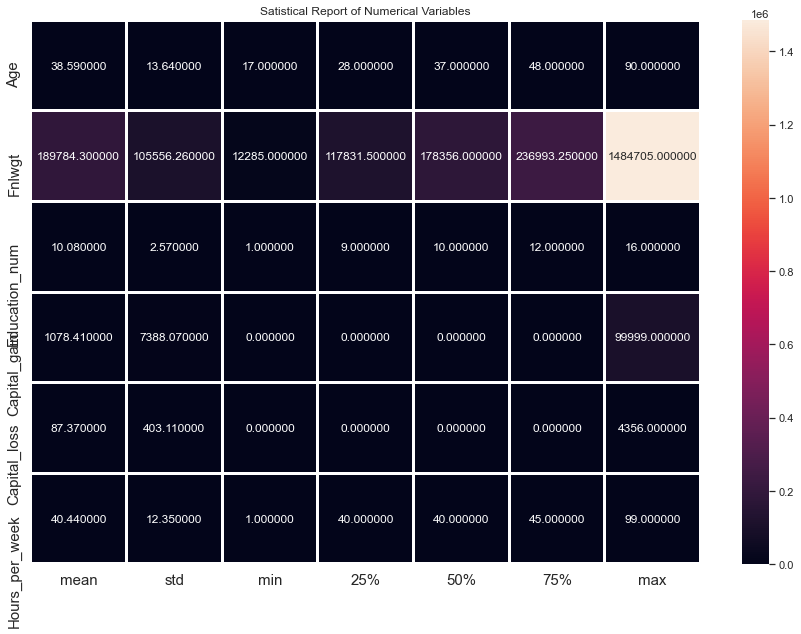

In [10]:
#visualizing statistical description of dataset
plt.figure(figsize = (15,10))
sns.heatmap(round(df.describe()[1:].transpose(),2),linewidth = 2,annot= True, fmt = "f")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Satistical Report of Numerical Variables")
plt.show()

- Age: 
    - Mean : 38.5855
    - Std : 13.6381
    - Min : 17
    - Max : 90
    
- Fnlwgt: 
    - Mean : 1.897 e+05
    - Std : 1.055 e+05
    - Min : 1.2285 e+05
    - Max : 1.4847 e+05
    
- Education_num: 
    - Mean : 10.0817
    - Std : 2.5716
    - Min : 1
    - Max : 16

- Capital_gain: 
    - Mean : 1078.41
    - Std : 7388.0684
    - Min : 0
    - Max : 99999
    
- Capital_loss: 
    - Mean : 87.3709
    - Std : 403.1077
    - Min : 0
    - Max : 4356
    
- Hours_per_week: 
    - Mean : 40.4403
    - Std : 12.3470
    - Min : 1
    - Max : 99
    


### Univariate Analysis

Text(0.5, 1.0, 'Age')

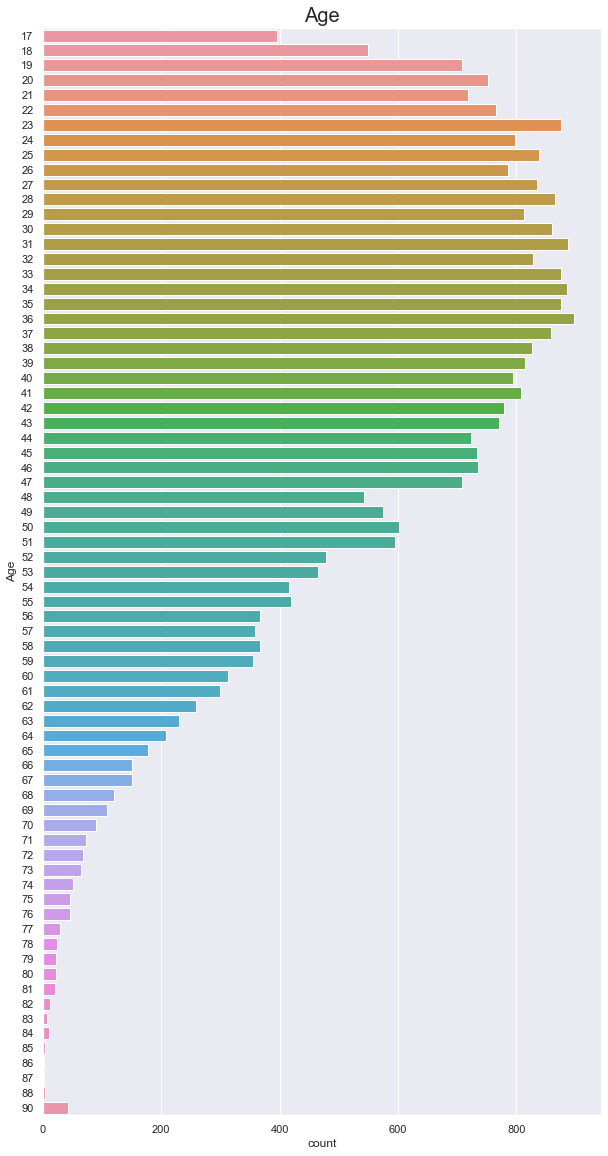

In [11]:
plt.figure(figsize = (10,20))
sns.countplot(data = df, y = 'Age')
plt.title("Age",fontsize = 20)

- We've Age Range from 17 - 90. 23-35 is the age group most appearing in dataset, which also points to having more census income.

Text(0.5, 1.0, 'Workclass Category Distribution')

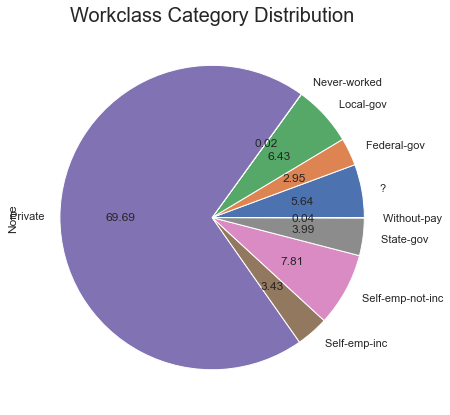

In [12]:
plt.figure(figsize = (7,7))

df.groupby('Workclass').size().plot(kind='pie', autopct='%.2f')
plt.title("Workclass Category Distribution", fontsize = 20)

- We've almost 70% people from Corporate sector.
- We've a missing category labeled as '?'

Text(0.5, 1.0, 'Marital Status Category Distribution')

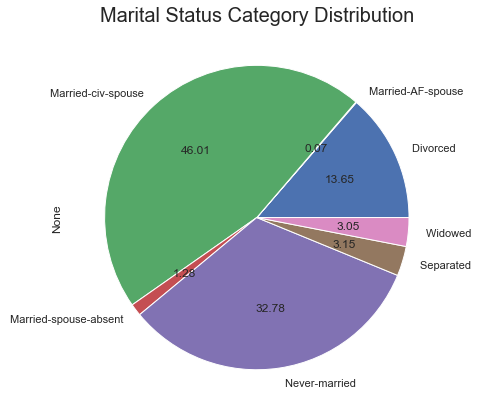

In [13]:
plt.figure(figsize = (7,7))
df.groupby('Marital_status').size().plot(kind='pie', autopct='%.2f')
plt.title("Marital Status Category Distribution", fontsize = 20)

- Distribution of categories in Marital_status

Text(0.5, 1.0, 'Occupation Category Distribution')

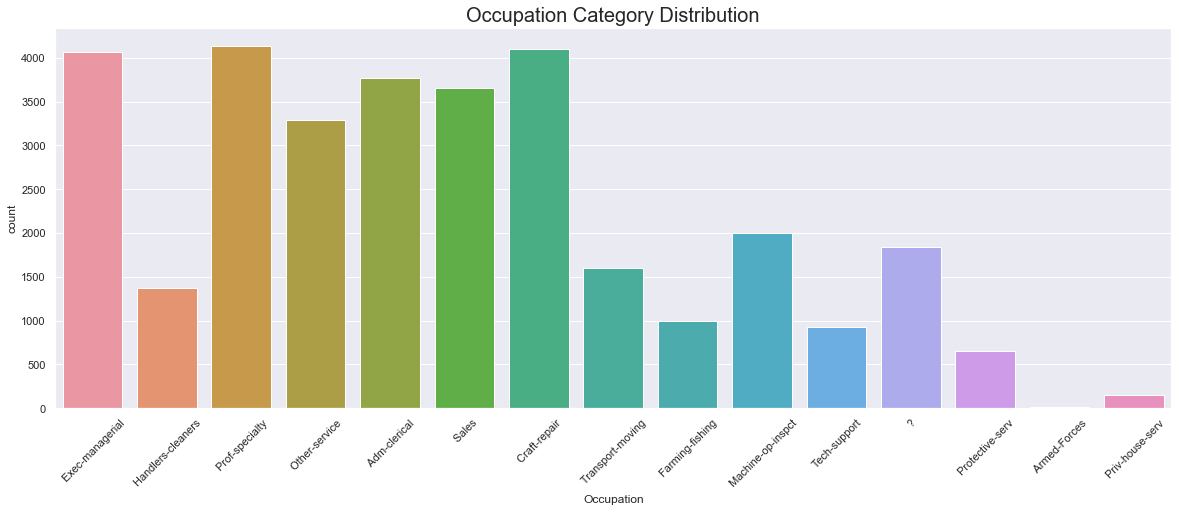

In [14]:
plt.figure(figsize = (20,7))
sns.countplot(df['Occupation'])
plt.xticks(rotation = 45)
plt.title("Occupation Category Distribution", fontsize = 20)

- We've missing data in Occupation Column labeled as '?'.

Text(0.5, 1.0, 'Education Category Distribution')

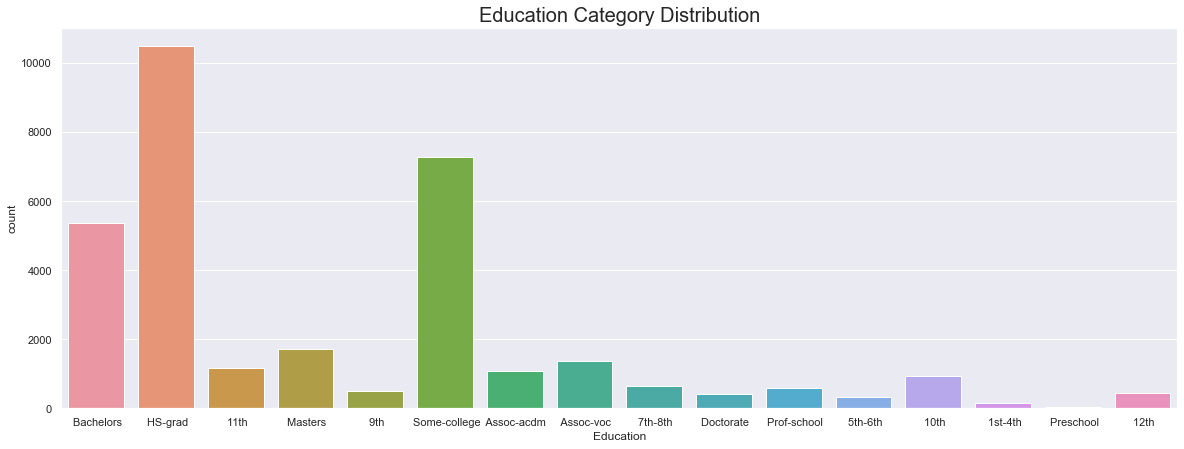

In [15]:
plt.figure(figsize = (20,7))
sns.countplot(df['Education'])
plt.title("Education Category Distribution", fontsize = 20)

- We've 16 different categories in Education starting from preschool to Doctorate and Masters.

Text(0.5, 1.0, 'Num of years spent on Education')

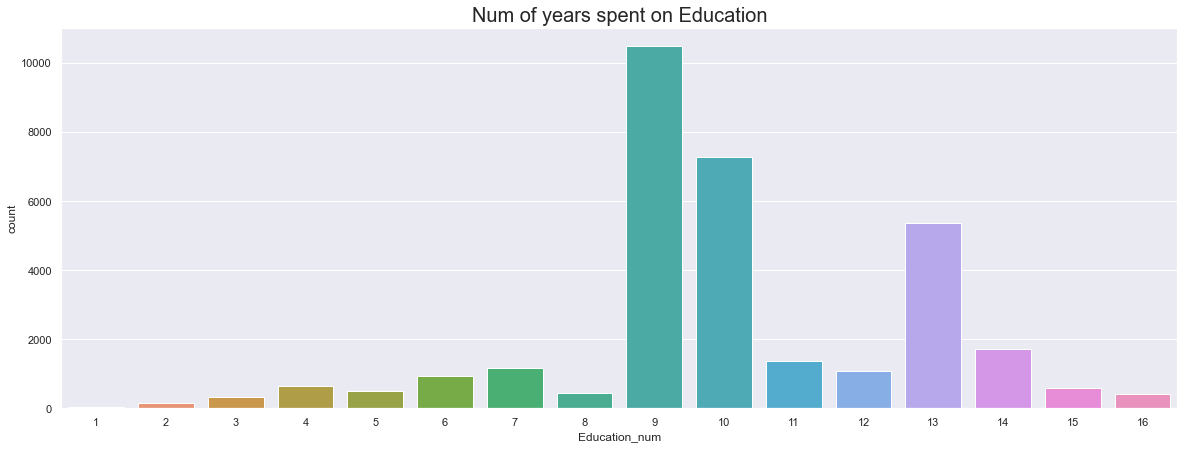

In [16]:
plt.figure(figsize = (20,7))
sns.countplot(df['Education_num'])
plt.title("Num of years spent on Education", fontsize = 20)

- Max number of years spent on education is 16, where as minimum educational years is 2.

Text(0.5, 1.0, 'Relationship Category Distribution')

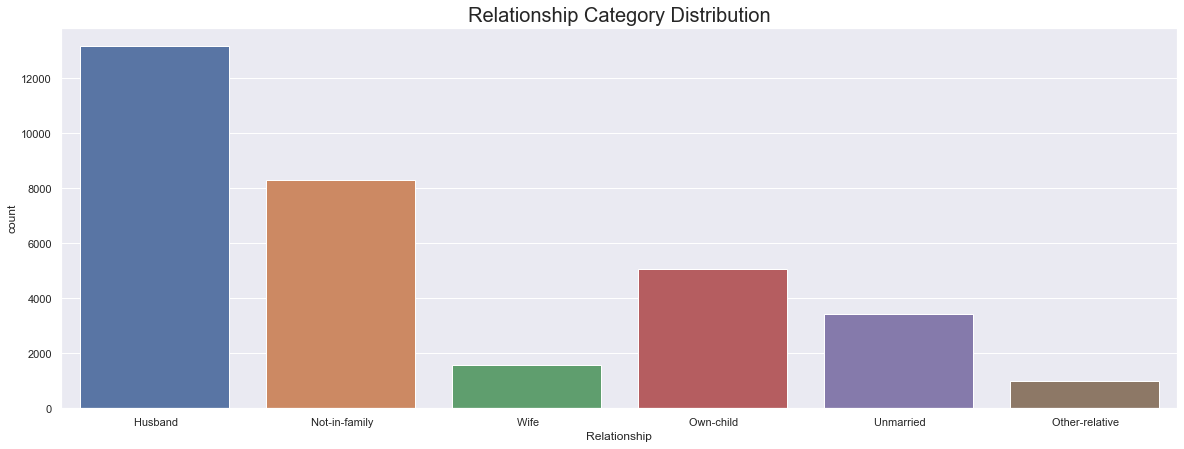

In [17]:
plt.figure(figsize = (20,7))
sns.countplot(df['Relationship'])
plt.title("Relationship Category Distribution", fontsize = 20)

- Role of an individual in their family.

Text(0.5, 1.0, 'Race Category Distribution')

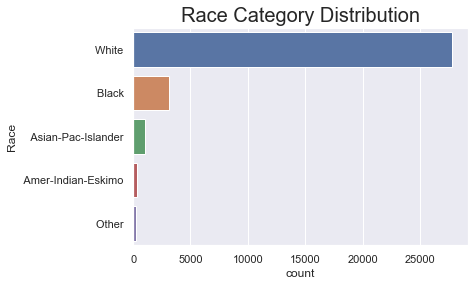

In [18]:
sns.countplot(data = df, y = 'Race')
plt.title("Race Category Distribution", fontsize = 20)

- 5 different Races with White being the most occured race.

Text(0.5, 1.0, 'Sex Category Distribution')

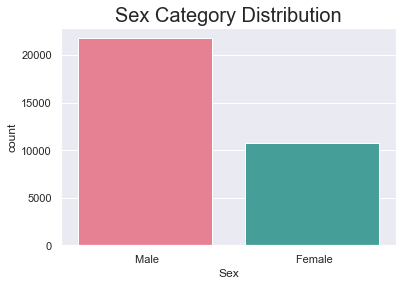

In [19]:
sns.countplot(df['Sex'], palette = 'husl')
plt.title("Sex Category Distribution", fontsize = 20)

- Male to female ratio is high.

Text(0.5, 1.0, 'Native Country')

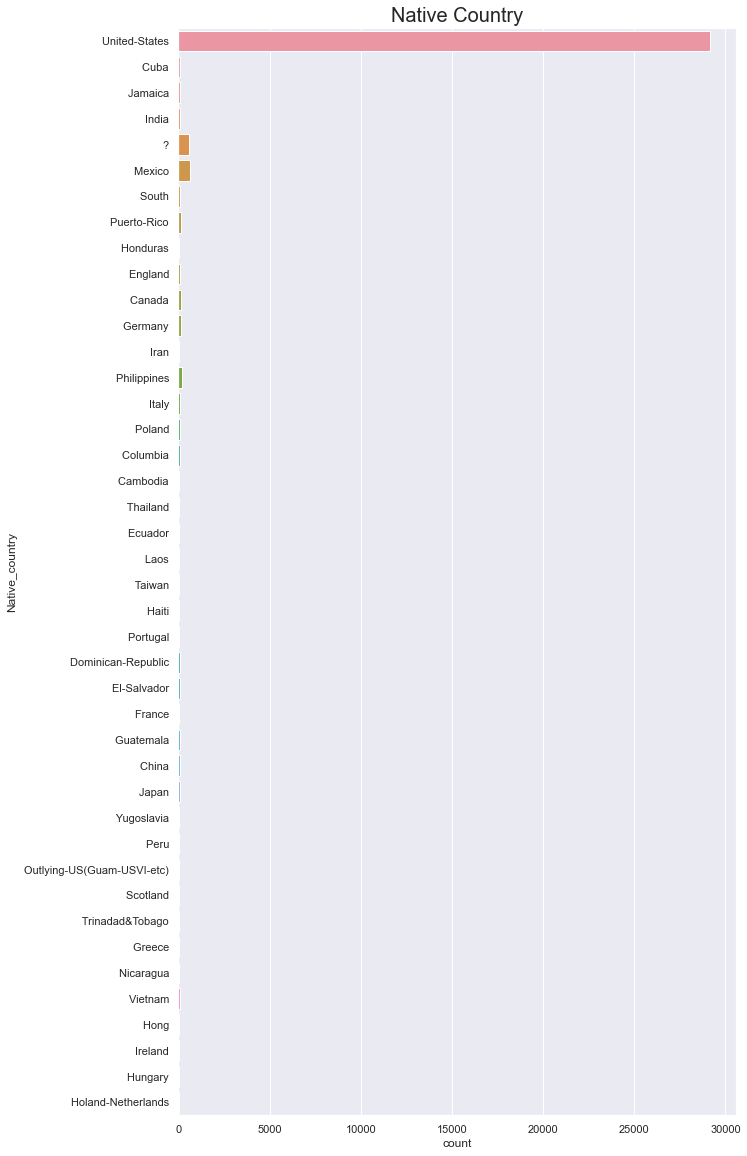

In [20]:
plt.figure(figsize = (10,20))
sns.countplot(data = df, y = 'Native_country')
plt.title("Native Country", fontsize = 20)

- Native country of an individual. United-States is the most occured country in our dataset.
- We've a mislabeled data "?"

Text(0.5, 1.0, 'Distribution of Age')

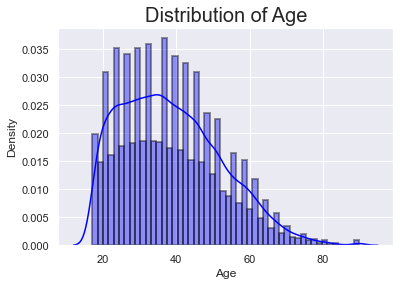

In [21]:
sns.distplot(df['Age'], color = 'blue',hist_kws=dict(edgecolor="black", linewidth=2))
plt.title("Distribution of Age", fontsize = 20)

- There's skewness in Age Column.

### Bivariate Analysis


Text(0.5, 1.0, 'Distribution of Income over Age')

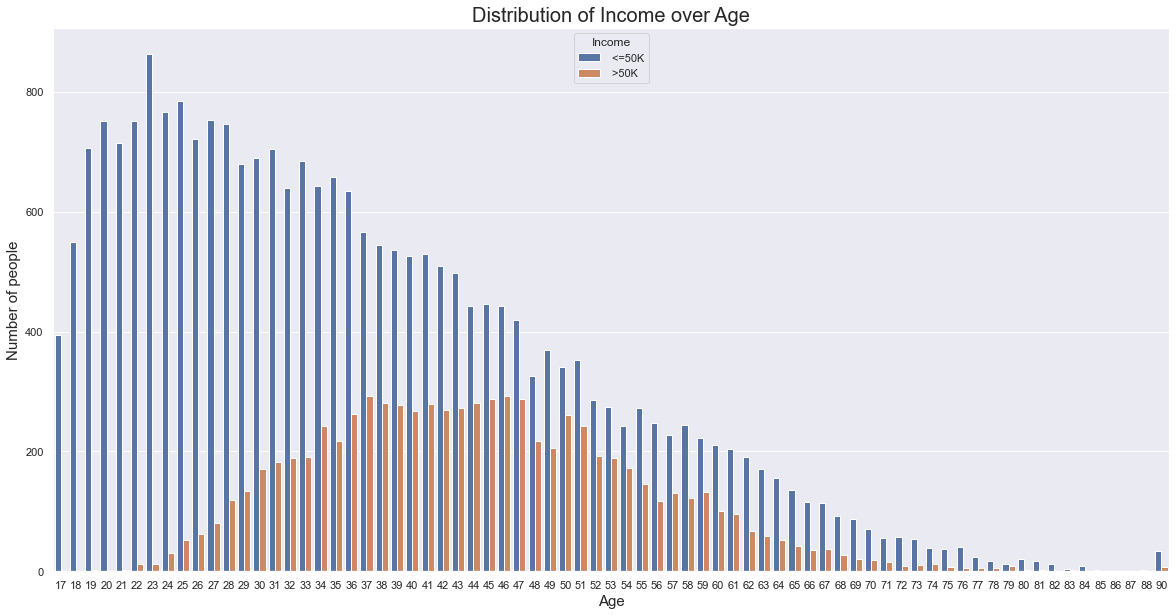

In [22]:
plt.figure(figsize = (20,10))
sns.countplot(data = df, x = 'Age', hue ='Income')
plt.xlabel("Age",fontsize = 15)
plt.ylabel("Number of people", fontsize = 15)
plt.title("Distribution of Income over Age", fontsize = 20)

- Between Age (37-47) is the peak age group where people earn more than 50k$. 

Text(0.5, 1.0, 'Distribution of Income over Education')

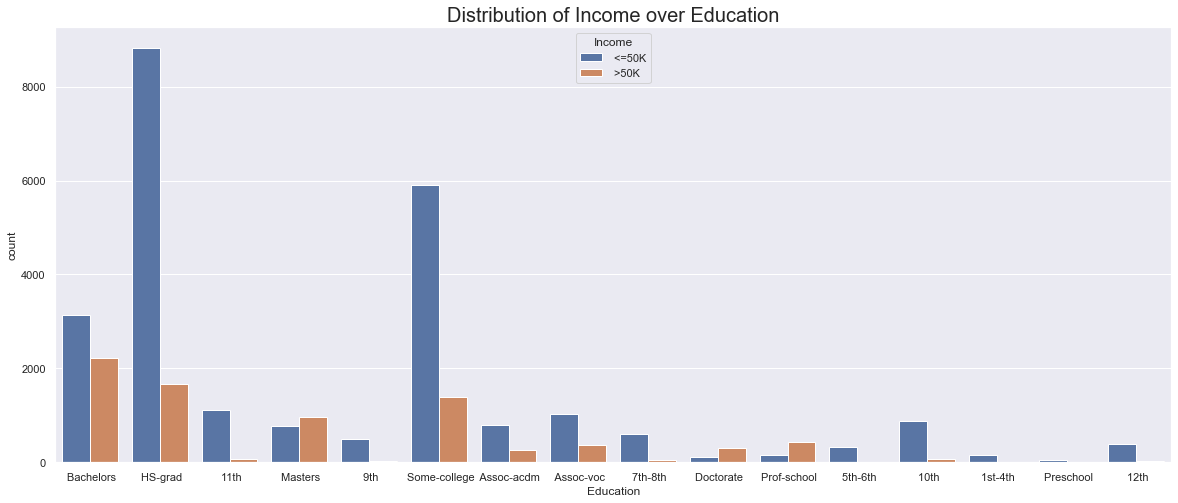

In [23]:
plt.figure(figsize = (20,8))
sns.countplot(data = df, x='Education', hue = 'Income')
plt.title("Distribution of Income over Education", fontsize = 20)

- People with Bachelors degree tend to have earnings more than 50k followed by people by HS-grad.
- People with HS- grad mostly have less than 50k earnings.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, ' Exec-managerial'),
  Text(1, 0, ' Handlers-cleaners'),
  Text(2, 0, ' Prof-specialty'),
  Text(3, 0, ' Other-service'),
  Text(4, 0, ' Adm-clerical'),
  Text(5, 0, ' Sales'),
  Text(6, 0, ' Craft-repair'),
  Text(7, 0, ' Transport-moving'),
  Text(8, 0, ' Farming-fishing'),
  Text(9, 0, ' Machine-op-inspct'),
  Text(10, 0, ' Tech-support'),
  Text(11, 0, ' ?'),
  Text(12, 0, ' Protective-serv'),
  Text(13, 0, ' Armed-Forces'),
  Text(14, 0, ' Priv-house-serv')])

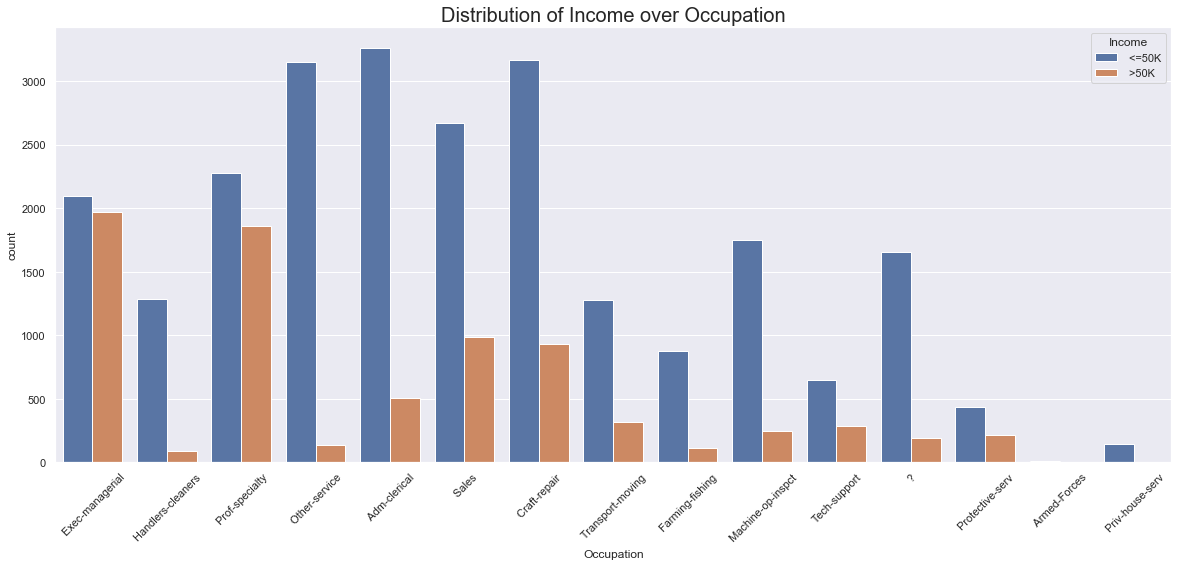

In [24]:
plt.figure(figsize = (20,8))
sns.countplot(data = df, x='Occupation', hue = 'Income')
plt.title("Distribution of Income over Occupation", fontsize = 20)
plt.xticks(rotation = 45)

- Exec- Managerial post employees tend to earn more than 50k followed by prof-speciality.

Text(0.5, 1.0, 'Distribution of Income over Workclass')

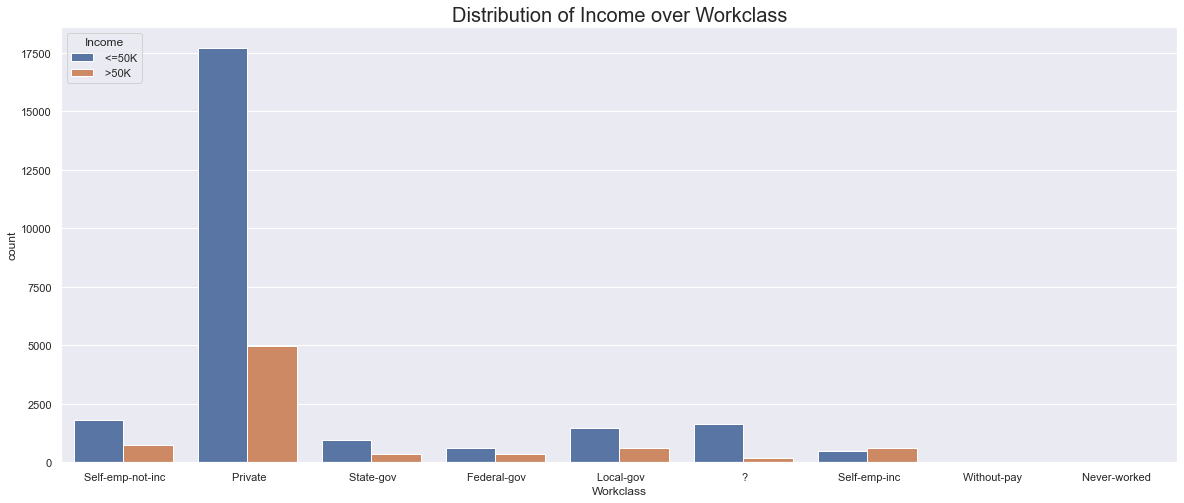

In [25]:
plt.figure(figsize = (20,8))
sns.countplot(data = df, x='Workclass', hue = 'Income')
plt.title("Distribution of Income over Workclass", fontsize = 20)

- Private Sector employees tend to earn more than 50k. 

Text(0.5, 1.0, 'Distribution of Income over Years of Education')

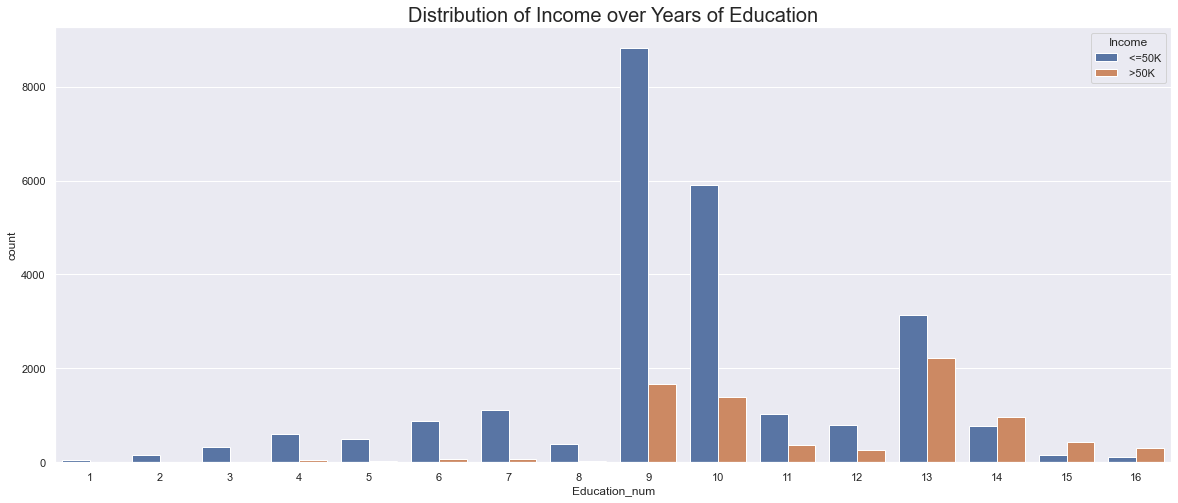

In [26]:
plt.figure(figsize = (20,8))
sns.countplot(data = df, x='Education_num', hue = 'Income')
plt.title("Distribution of Income over Years of Education", fontsize = 20)

- People with 13 years of education tend to have more than 50k earnings.
- people with 9 years of education mostly earns less than 50k.

Text(0.5, 1.0, 'Distribution of Income over Marital Status')

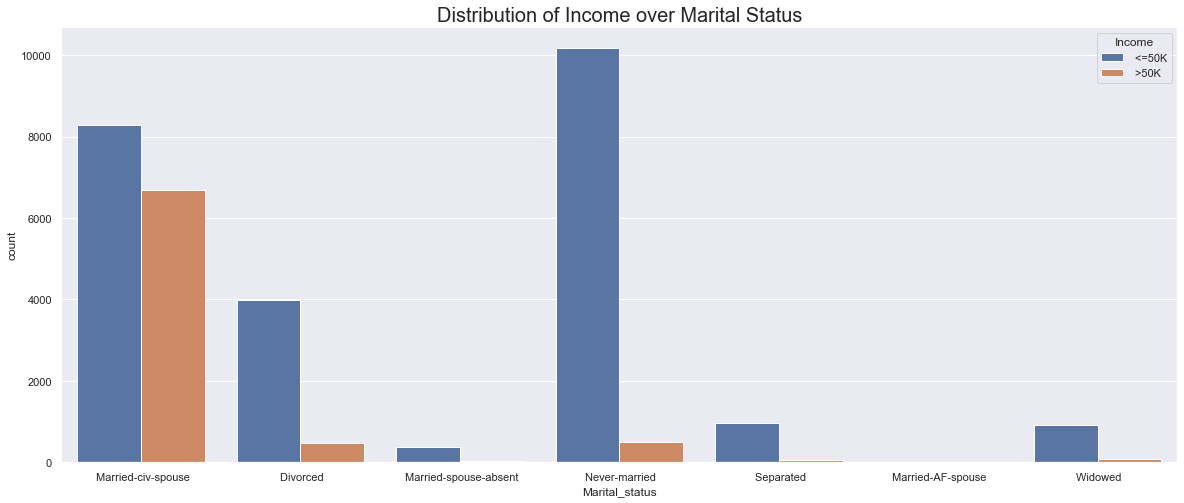

In [27]:
plt.figure(figsize = (20,8))
sns.countplot(data = df, x='Marital_status', hue = 'Income')
plt.title("Distribution of Income over Marital Status", fontsize = 20)

- People married with a spouse have more than 50k earnings.
- People who've never married mostly earn less than 50k.

Text(0.5, 1.0, 'Distribution of Income over Race')

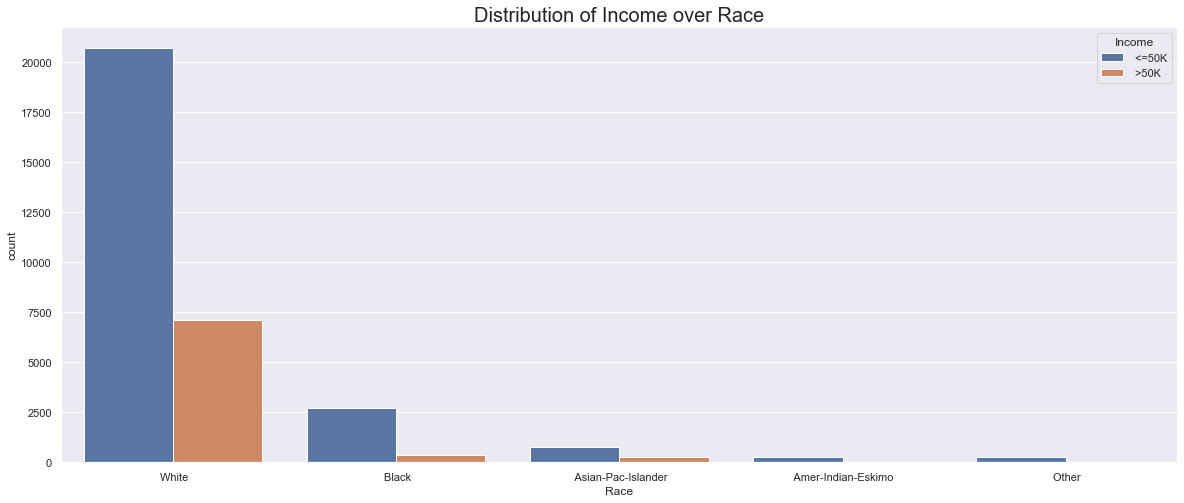

In [28]:
plt.figure(figsize = (20,8))
sns.countplot(data = df, x='Race', hue = 'Income')
plt.title("Distribution of Income over Race", fontsize = 20)

- White people tend to earn more than 50k  among all the other races.

Text(0.5, 1.0, 'Distribution of Income over Sex')

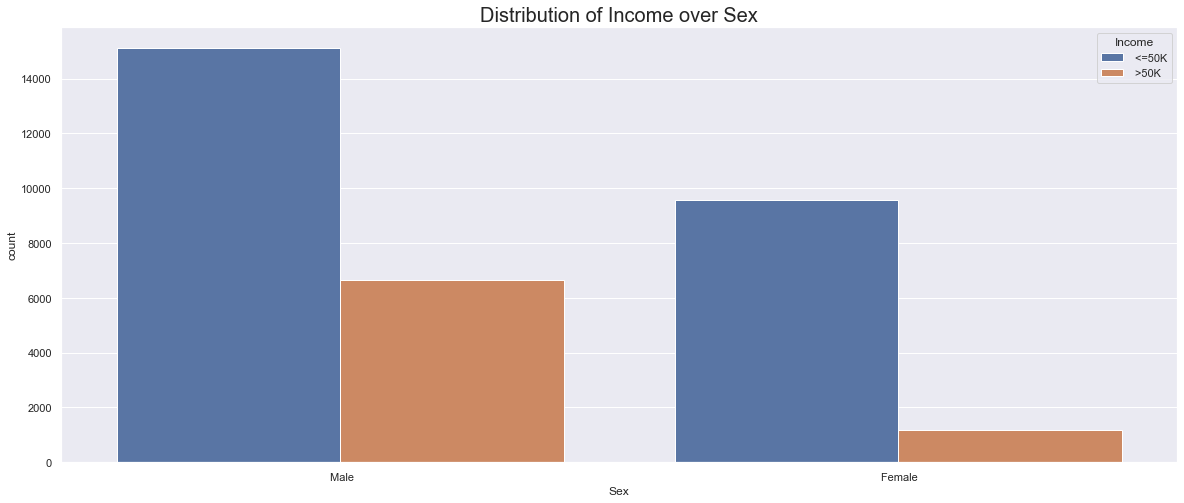

In [29]:
plt.figure(figsize = (20,8))
sns.countplot(data = df, x='Sex', hue = 'Income')
plt.title("Distribution of Income over Sex", fontsize = 20)

- Males earn more than 50k Income as compared to Females.

### Multivariate Analysis

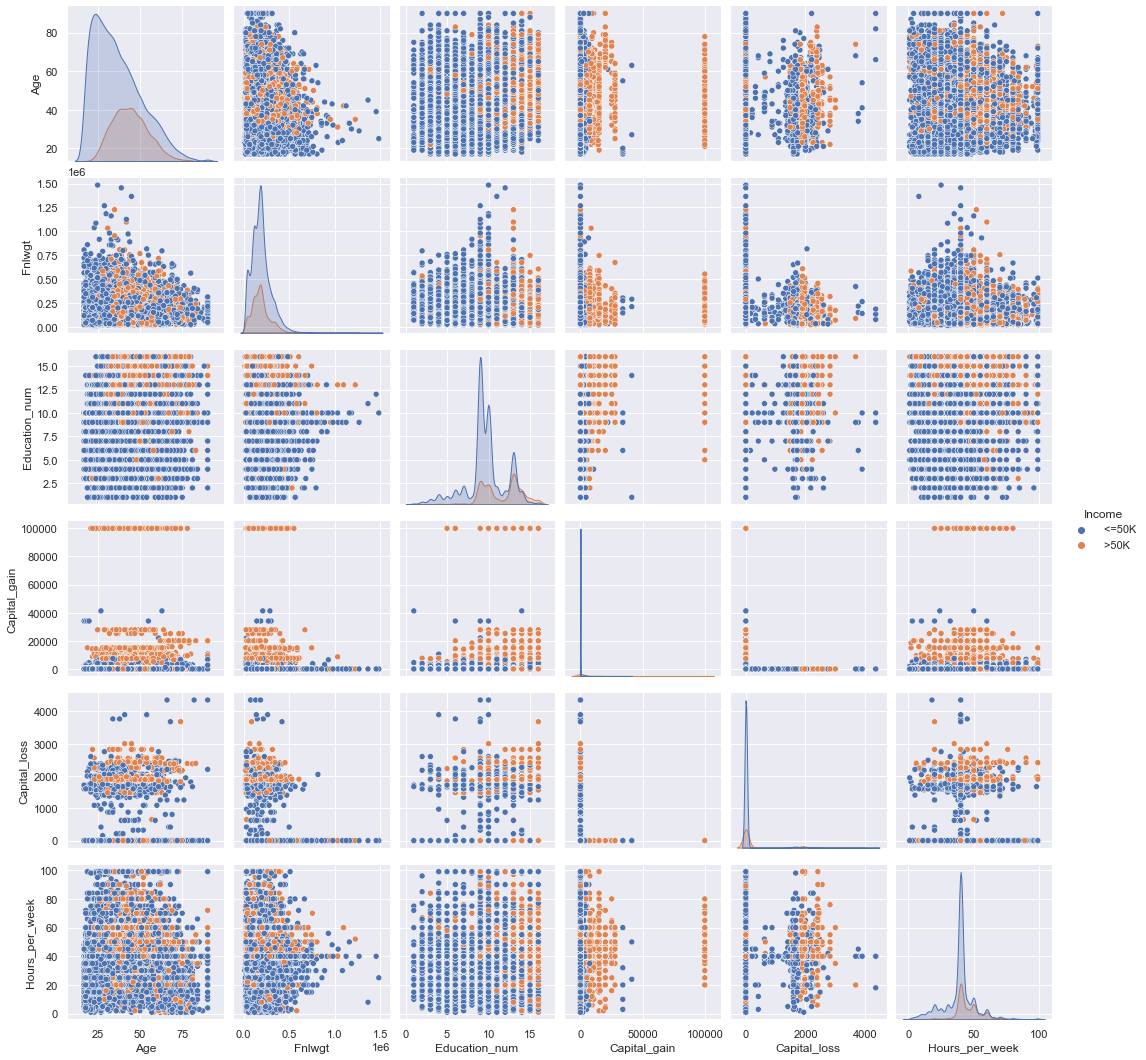

In [30]:
sns.pairplot(df, hue = 'Income')

- We do not have multicollinearity problem in our dataset.

In [31]:
#Analysing Correlation Matrix
df.corr()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
Age,1.000000,-0.076448,0.036224,0.077676,0.057745,0.068515
Fnlwgt,-0.076448,1.000000,-0.043353,0.000433,-0.010267,-0.018900
Education_num,0.036224,-0.043353,1.000000,0.122661,0.079901,0.148426
Capital_gain,0.077676,0.000433,0.122661,1.000000,-0.031638,0.078408
Capital_loss,0.057745,-0.010267,0.079901,-0.031638,1.000000,0.054229
Hours_per_week,0.068515,-0.018900,0.148426,0.078408,0.054229,1.000000


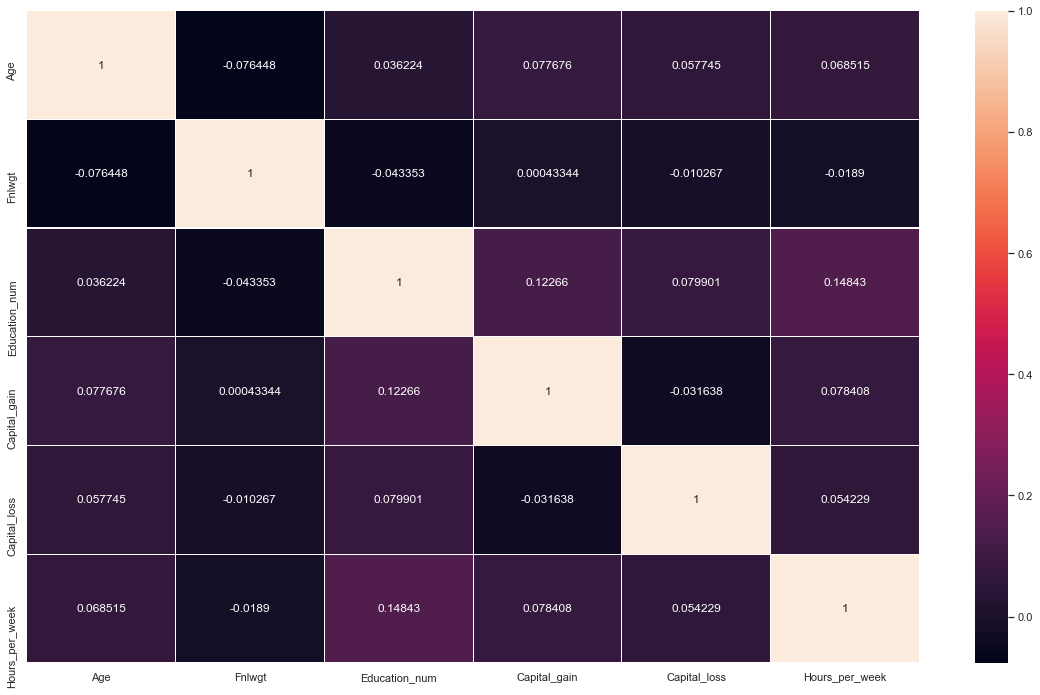

In [32]:
#plotting correlation table
plt.figure(figsize = [20,12])
sns.heatmap(df.corr(), annot = True,linewidths=0.1,fmt = '.5g' )
plt.show()

- We do not have multicollinearity problem in our dataset.

### Data Cleaning 

__Workclass__ : We've a mislabeled category "?" in our column. We can replace it with the mode(most occurred).

 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64


<AxesSubplot:xlabel='Workclass', ylabel='count'>

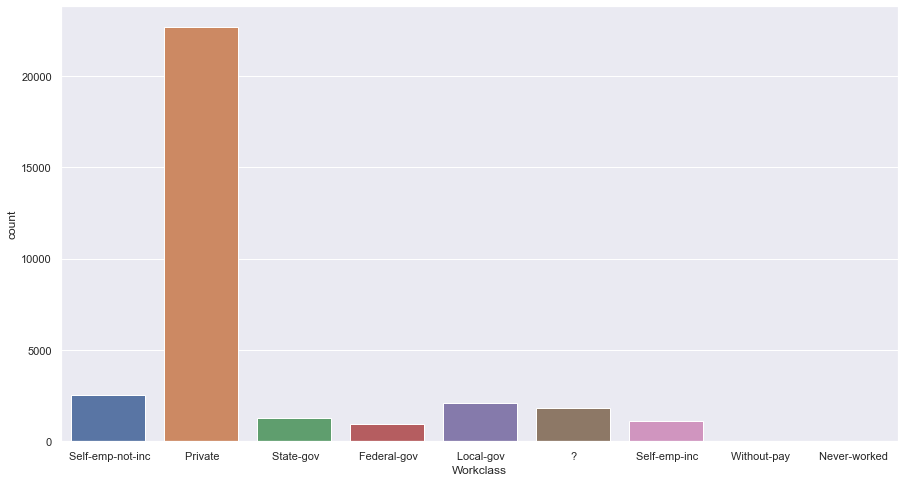

In [33]:
#Analysing Workclass column and it's missing values
print(df['Workclass'].value_counts())
plt.figure(figsize = (15,8))
sns.countplot(df['Workclass'])

In [34]:
#Getting Mode of Workclass
df['Workclass'].mode()

0     Private
dtype: object

In [35]:
#Replacing missing values with most occured value in the column
df['Workclass'] = df['Workclass'].str.replace('?', 'Private')

In [36]:
#Rechecking the new Categories
df['Workclass'].value_counts()

 Private             24509
 Self-emp-not-inc     2540
 Local-gov            2093
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

<AxesSubplot:xlabel='Workclass', ylabel='count'>

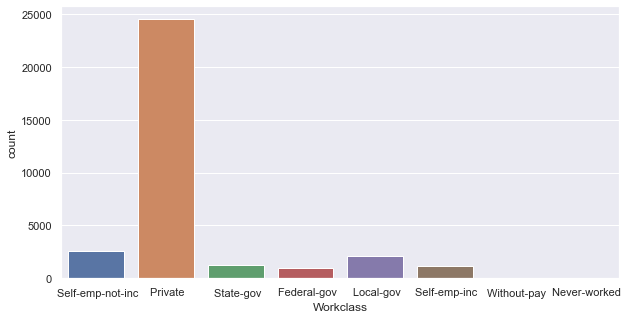

In [37]:
#Plotting new categories
plt.figure(figsize= (10,5))
sns.countplot(df['Workclass'])

__Occupation__ : We've a mislabeled category in occupation as well which we'll replace with mode.

 Prof-specialty       4136
 Craft-repair         4094
 Exec-managerial      4065
 Adm-clerical         3767
 Sales                3650
 Other-service        3291
 Machine-op-inspct    2000
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1369
 Farming-fishing       992
 Tech-support          927
 Protective-serv       649
 Priv-house-serv       147
 Armed-Forces            9
Name: Occupation, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, ' Exec-managerial'),
  Text(1, 0, ' Handlers-cleaners'),
  Text(2, 0, ' Prof-specialty'),
  Text(3, 0, ' Other-service'),
  Text(4, 0, ' Adm-clerical'),
  Text(5, 0, ' Sales'),
  Text(6, 0, ' Craft-repair'),
  Text(7, 0, ' Transport-moving'),
  Text(8, 0, ' Farming-fishing'),
  Text(9, 0, ' Machine-op-inspct'),
  Text(10, 0, ' Tech-support'),
  Text(11, 0, ' ?'),
  Text(12, 0, ' Protective-serv'),
  Text(13, 0, ' Armed-Forces'),
  Text(14, 0, ' Priv-house-serv')])

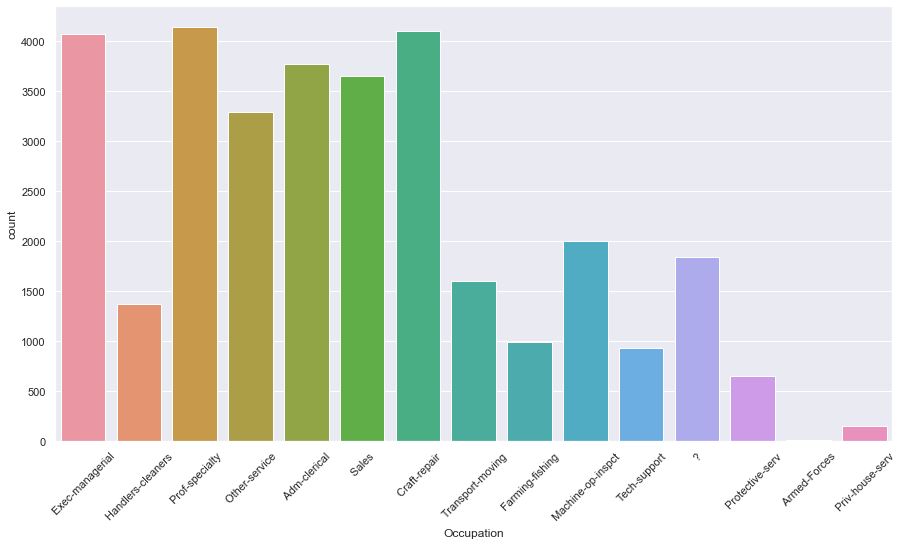

In [38]:
#Analysing Workclass column and it's missing values

print(df['Occupation'].value_counts())
plt.figure(figsize = (15,8))
sns.countplot(df['Occupation'])
plt.xticks(rotation = 45)

In [39]:
#Interpreting mode
df['Occupation'].mode()

0     Prof-specialty
dtype: object

In [40]:
#Replacing missing values with mode
df['Occupation'] = df['Occupation'].str.replace('?', 'Prof-specialty')

 Prof-specialty       5979
 Craft-repair         4094
 Exec-managerial      4065
 Adm-clerical         3767
 Sales                3650
 Other-service        3291
 Machine-op-inspct    2000
 Transport-moving     1597
 Handlers-cleaners    1369
 Farming-fishing       992
 Tech-support          927
 Protective-serv       649
 Priv-house-serv       147
 Armed-Forces            9
Name: Occupation, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, ' Exec-managerial'),
  Text(1, 0, ' Handlers-cleaners'),
  Text(2, 0, ' Prof-specialty'),
  Text(3, 0, ' Other-service'),
  Text(4, 0, ' Adm-clerical'),
  Text(5, 0, ' Sales'),
  Text(6, 0, ' Craft-repair'),
  Text(7, 0, ' Transport-moving'),
  Text(8, 0, ' Farming-fishing'),
  Text(9, 0, ' Machine-op-inspct'),
  Text(10, 0, ' Tech-support'),
  Text(11, 0, ' Protective-serv'),
  Text(12, 0, ' Armed-Forces'),
  Text(13, 0, ' Priv-house-serv')])

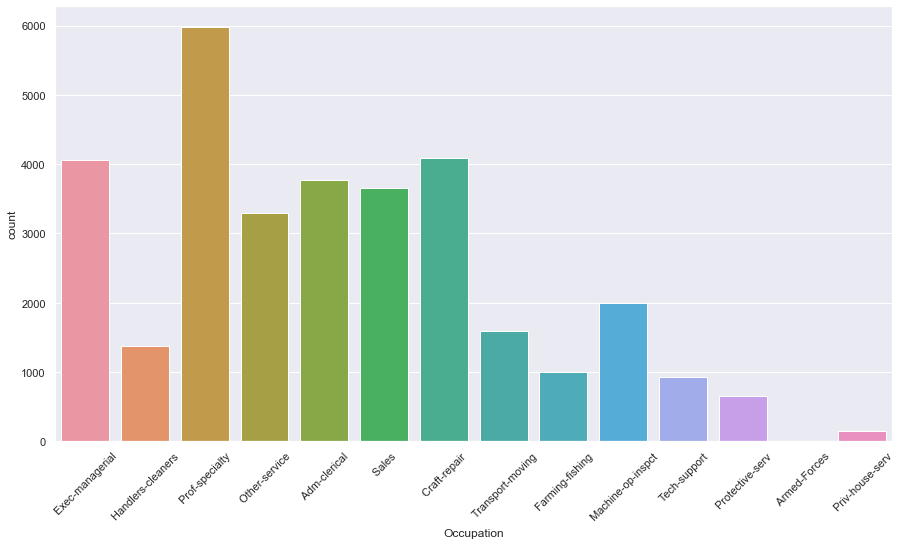

In [41]:
#Rechecking the replaced values
print(df['Occupation'].value_counts())
plt.figure(figsize = (15,8))
sns.countplot(df['Occupation'])
plt.xticks(rotation = 45)

__Native-Country__ : We've a mislabeled category "?" in our column. We can replace it with the mode(most occurred).

 United-States                 29152
 Mexico                          639
 ?                               582
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        62
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

<AxesSubplot:xlabel='count', ylabel='Native_country'>

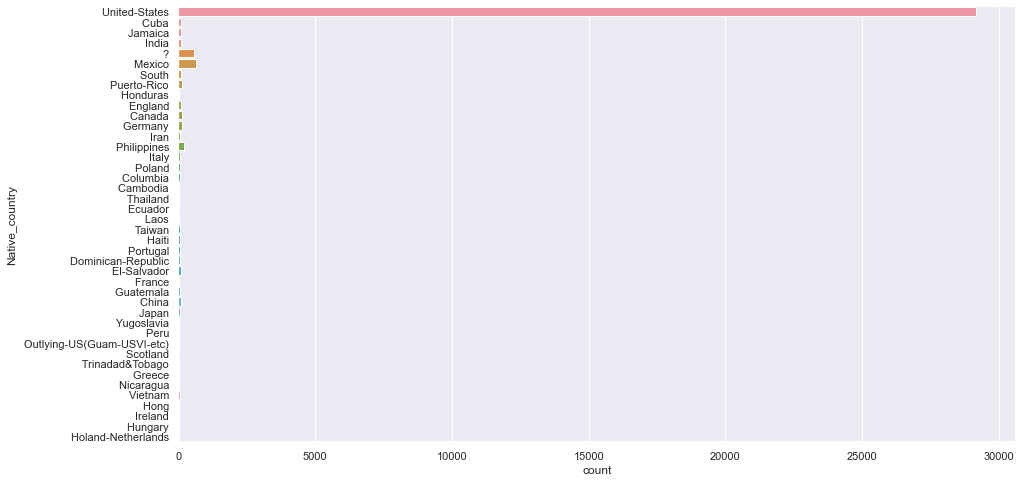

In [42]:
#Analysing our column labels
print(df['Native_country'].value_counts())
plt.figure(figsize = (15,8))
sns.countplot(data = df, y ='Native_country')

In [43]:
#Interpretting mode
df['Native_country'].mode()

0     United-States
dtype: object

In [44]:
#Replacing missing values with mode
df['Native_country'] = df['Native_country'].str.replace('?', 'United-States')

<AxesSubplot:xlabel='count', ylabel='Native_country'>

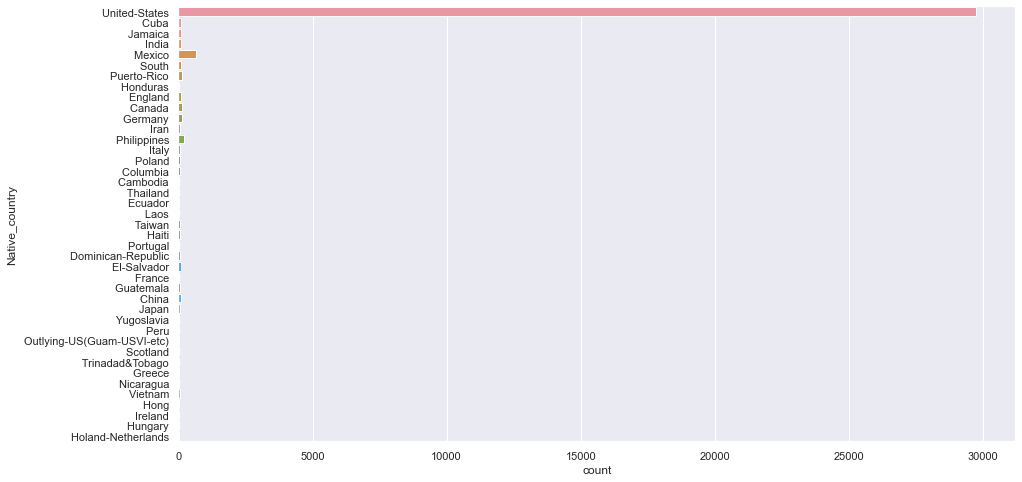

In [45]:
#analysing again to check the replaced values
plt.figure(figsize = (15,8))
sns.countplot(data = df, y ='Native_country')

##### Encoding our Target variable using label encoder.

In [46]:
enc = LabelEncoder()
df['Income'] = enc.fit_transform(df['Income'])

In [47]:
#Splitting our Dataset into Features and Target
X = df.drop(columns = ['Income'],axis = 1)
y = df['Income']

##### Encoding our Categorical Features using Ordinal Encoder.

In [48]:
ord_enc = OrdinalEncoder()
X1 = pd.DataFrame(ord_enc.fit_transform(df[['Workclass','Education','Marital_status','Occupation','Relationship','Race','Sex','Native_country']]),
                  columns = ['Workclass','Education','Marital_status','Occupation','Relationship','Race','Sex','Native_country'])
X1

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country
0,5.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0
1,3.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0
2,3.0,1.0,2.0,5.0,0.0,2.0,1.0,38.0
3,3.0,9.0,2.0,9.0,5.0,2.0,0.0,4.0
4,3.0,12.0,2.0,3.0,5.0,4.0,0.0,38.0
...,...,...,...,...,...,...,...,...
32531,3.0,7.0,2.0,12.0,5.0,4.0,0.0,38.0
32532,3.0,11.0,2.0,6.0,0.0,4.0,1.0,38.0
32533,3.0,11.0,6.0,0.0,4.0,4.0,0.0,38.0
32534,3.0,11.0,4.0,0.0,3.0,4.0,1.0,38.0


In [49]:
df.drop(columns = ['Workclass','Education','Marital_status','Occupation','Relationship','Race','Sex','Native_country'], inplace = True)

In [50]:
frames = [df,X1]

In [51]:
df = pd.concat(frames,axis = 1)

In [52]:
df = df[:32536]

In [53]:
X = df.drop('Income',axis = 1)
y = df['Income']

In [54]:
X.dropna(inplace = True)
y.dropna(inplace = True)

### Using KSelect Best features to choose Features

In [55]:
# Selecting k as 8
best_features = SelectKBest(score_func=f_classif, k=8)
fit = best_features.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

#concatenate dataframes
feature_scores = pd.concat([df_columns,df_scores], axis=1)
feature_scores.columns = ['Feature_Name', 'Score']

#Sorting in Descending order
print(feature_scores.nlargest(8,'Score'))

      Feature_Name        Score
2    Education_num  4118.865829
0              Age  1883.552242
5   Hours_per_week  1815.515900
3     Capital_gain  1705.047270
4     Capital_loss   754.048133
10    Relationship    37.699324
8   Marital_status    29.615789
12             Sex    28.008302


In [56]:
X.columns

Index(['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss',
       'Hours_per_week', 'Workclass', 'Education', 'Marital_status',
       'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country'],
      dtype='object')

In [57]:
#Dropping columns which ar not in top 8 
X.drop(columns = ['Fnlwgt','Occupation','Race','Native_country','Workclass','Education'],axis=1,inplace = True)

### Balancing Target Variable Class using OverSampling method SMOTE.

<AxesSubplot:xlabel='Income', ylabel='count'>

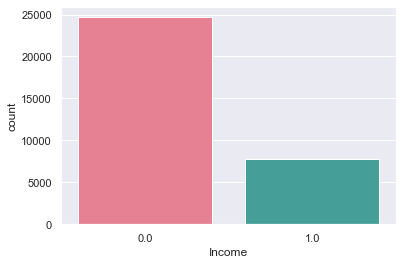

In [58]:
#Visualising Class Imbalance
sns.countplot(y,palette = 'husl')

In [59]:
#instantiating and fitting Smote
sm = SMOTE()
X_smote, y_smote = sm.fit_resample(X,y)

In [60]:
#print Count of class before oversampling and after oversampling
print('Before SMOTE : ',Counter(y))
print('After SMOTE : ',Counter(y_smote))

Before SMOTE :  Counter({0.0: 24679, 1.0: 7833})
After SMOTE :  Counter({0.0: 24679, 1.0: 24679})


<AxesSubplot:xlabel='Income', ylabel='count'>

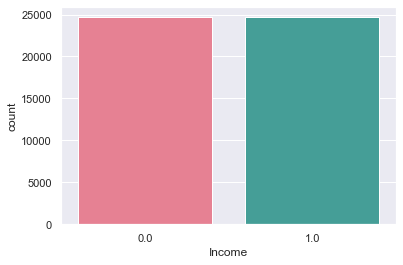

In [61]:
#Univariate Analysis
#Plotting the balanced class
sns.countplot(y_smote, palette = 'husl')

## Model Building

### Logistic Regression

In [62]:
#Finding Random state using LogisticRegression
maxAccu=0
maxRS = 0
for i in range(1,200):
    x_train,x_test,y_train,y_test = train_test_split(X_smote,y_smote,test_size=0.2,random_state=i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    predlr = LR.predict(x_test)
    acc = accuracy_score(y_test,predlr)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is",maxAccu,"on random_state",maxRS)

Best accuracy is 0.7025931928687196 on random_state 102


In [65]:
#Instantiating and training our Logistic Regression Model
LR = LogisticRegression(random_state = 102)
LR.fit(x_train,y_train)
predlr = LR.predict(x_test)
acc = accuracy_score(y_test,predlr)
acc

0.6705834683954619

In [66]:
# Performing Evaluation metrics for our model
predlr=LR.predict(x_test)
print('Accuracy Score for Logistic Regression is :',round(accuracy_score(y_test,predlr),4)*100,'% \n')
print('Confusion Matrix of Logistic Regression : \n',confusion_matrix(y_test,predlr), '\n')
print('Classification Logistic Regression : \n',classification_report(y_test,predlr))

Accuracy Score for Logistic Regression is : 67.06 % 

Confusion Matrix of Logistic Regression : 
 [[3489 1511]
 [1741 3131]] 

Classification Logistic Regression : 
               precision    recall  f1-score   support

         0.0       0.67      0.70      0.68      5000
         1.0       0.67      0.64      0.66      4872

    accuracy                           0.67      9872
   macro avg       0.67      0.67      0.67      9872
weighted avg       0.67      0.67      0.67      9872



array([[3489, 1511],
       [1741, 3131]], dtype=int64)

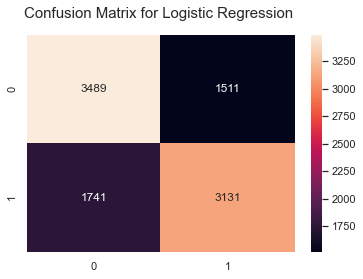

In [67]:
cm = confusion_matrix(y_test,predlr)

#visualize confusion matrix 
sns.heatmap(confusion_matrix(y_test,predlr),annot=True,fmt='3.0f')
plt.title('Confusion Matrix for Logistic Regression ', y=1.05, size=15)
cm

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

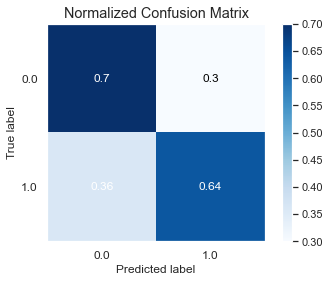

In [68]:
#Plotting Confusion Matrix Adaptive Boost model
skplt.metrics.plot_confusion_matrix(y_test, predlr, normalize=True)

### Decision Tree Classifier

In [69]:
#Splitting Dataset into 80% Training and 20% testing Data
X_train,X_test,y_train,y_test = train_test_split(X_smote,y_smote,test_size=0.2,random_state=102)

In [70]:
#Instantiating Decision Tree model and training it
DT = DecisionTreeClassifier()
DT.fit(X_train,y_train)

DecisionTreeClassifier()

In [71]:
# Performing Evaluation metrics for our model
preddt=DT.predict(X_test)
print('Accuracy Score for Decision Treee is :',round(accuracy_score(y_test,preddt),4)*100,'% \n')
print('Confusion Matrix of Decision Tree: \n',confusion_matrix(y_test,preddt), '\n')
print('Classification Decision Tree: \n',classification_report(y_test,preddt))

Accuracy Score for Decision Treee is : 83.1 % 

Confusion Matrix of Decision Tree: 
 [[4183  785]
 [ 883 4021]] 

Classification Decision Tree: 
               precision    recall  f1-score   support

         0.0       0.83      0.84      0.83      4968
         1.0       0.84      0.82      0.83      4904

    accuracy                           0.83      9872
   macro avg       0.83      0.83      0.83      9872
weighted avg       0.83      0.83      0.83      9872



array([[4183,  785],
       [ 883, 4021]], dtype=int64)

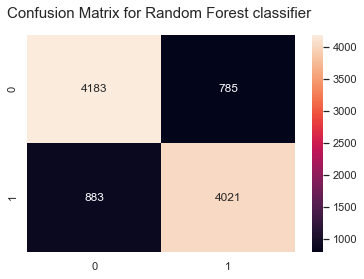

In [72]:
cm = confusion_matrix(y_test,preddt)
#visualize confusion matrix 
sns.heatmap(confusion_matrix(y_test,preddt),annot=True,fmt='3.0f')
plt.title('Confusion Matrix for Random Forest classifier ', y=1.05, size=15)
cm

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

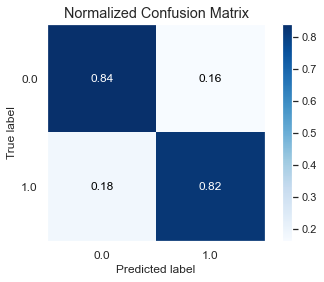

In [73]:
#Plotting Confusion Matrix Adaptive Boost model
skplt.metrics.plot_confusion_matrix(y_test, preddt, normalize=True)

### KNeighbors Classifier

In [74]:
#Instantiating KnN model and training it
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

In [75]:
# Performing Evaluation metrics for our model
knnpred=knn.predict(X_test)
print('Accuracy Score for KNN is :',round(accuracy_score(y_test,knnpred),4)*100,'% \n')
print('Confusion Matrix of KNN: \n',confusion_matrix(y_test,knnpred), '\n')
print('Classification KNN: \n',classification_report(y_test,knnpred))

Accuracy Score for KNN is : 81.16 % 

Confusion Matrix of KNN: 
 [[3809 1159]
 [ 701 4203]] 

Classification KNN: 
               precision    recall  f1-score   support

         0.0       0.84      0.77      0.80      4968
         1.0       0.78      0.86      0.82      4904

    accuracy                           0.81      9872
   macro avg       0.81      0.81      0.81      9872
weighted avg       0.81      0.81      0.81      9872



array([[3809, 1159],
       [ 701, 4203]], dtype=int64)

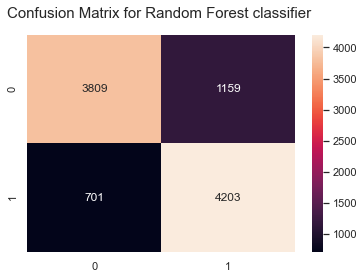

In [76]:
cm = confusion_matrix(y_test,knnpred)
#visualize confusion matrix 
sns.heatmap(confusion_matrix(y_test,knnpred),annot=True,fmt='3.0f')
plt.title('Confusion Matrix for Random Forest classifier ', y=1.05, size=15)
cm

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

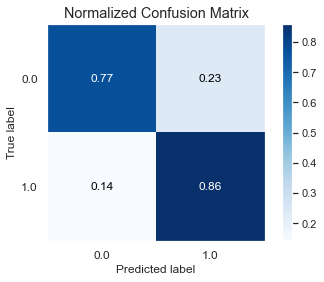

In [77]:
#Plotting Confusion Matrix Adaptive Boost model
skplt.metrics.plot_confusion_matrix(y_test, knnpred, normalize=True)

### Random Forest Classifier

In [78]:
#Model instantiating and traaining it
RF = RandomForestClassifier()
RF.fit(X_train,y_train)


RandomForestClassifier()

In [79]:
# Performing Evaluation metrics for our model
predrf=RF.predict(X_test)
print('Accuracy Score for Random Forest Classifier is :',round(accuracy_score(y_test,predrf),4)*100,'% \n')
print('Confusion Matrix of Random Forest Classifier : \n',confusion_matrix(y_test,predrf), '\n')
print('Classification Random Forest Classifier : \n',classification_report(y_test,predrf))

Accuracy Score for Random Forest Classifier is : 85.02 % 

Confusion Matrix of Random Forest Classifier : 
 [[4258  710]
 [ 769 4135]] 

Classification Random Forest Classifier : 
               precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      4968
         1.0       0.85      0.84      0.85      4904

    accuracy                           0.85      9872
   macro avg       0.85      0.85      0.85      9872
weighted avg       0.85      0.85      0.85      9872



array([[4258,  710],
       [ 769, 4135]], dtype=int64)

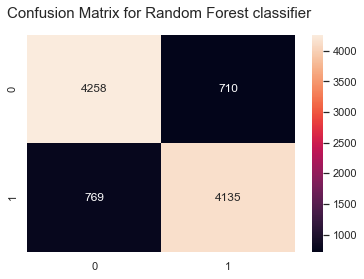

In [80]:
cm = confusion_matrix(y_test,predrf)
#visualize confusion matrix 
sns.heatmap(confusion_matrix(y_test,predrf),annot=True,fmt='3.0f')
plt.title('Confusion Matrix for Random Forest classifier ', y=1.05, size=15)
cm

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

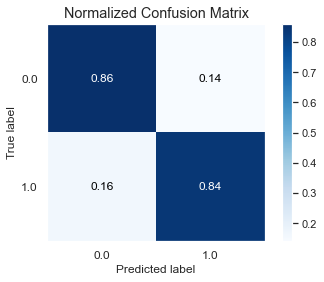

In [81]:
#Plotting Confusion Matrix Random Forest Classifier model
skplt.metrics.plot_confusion_matrix(y_test, predrf, normalize=True)

### Support Vector Classifier

In [82]:
#Instantiating SVC model and training it

svc  = SVC()
svc.fit(X_train,y_train)

SVC()

In [83]:
# Performing Evaluation metrics for our model
svcpred=svc.predict(X_test)
print('Accuracy Score for SVC is :',round(accuracy_score(y_test,svcpred),4)*100,'% \n')
print('Confusion Matrix of SVC: \n',confusion_matrix(y_test,svcpred), '\n')
print('Classification SVC: \n',classification_report(y_test,svcpred))

Accuracy Score for SVC is : 63.56 % 

Confusion Matrix of SVC: 
 [[4761  207]
 [3390 1514]] 

Classification SVC: 
               precision    recall  f1-score   support

         0.0       0.58      0.96      0.73      4968
         1.0       0.88      0.31      0.46      4904

    accuracy                           0.64      9872
   macro avg       0.73      0.63      0.59      9872
weighted avg       0.73      0.64      0.59      9872



array([[4761,  207],
       [3390, 1514]], dtype=int64)

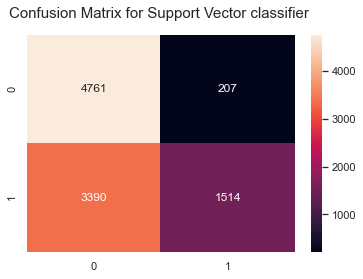

In [96]:
cm = confusion_matrix(y_test,svcpred)
#visualize confusion matrix 
sns.heatmap(confusion_matrix(y_test,svcpred),annot=True,fmt='3.0f')
plt.title('Confusion Matrix for Support Vector classifier ', y=1.05, size=15)
cm

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

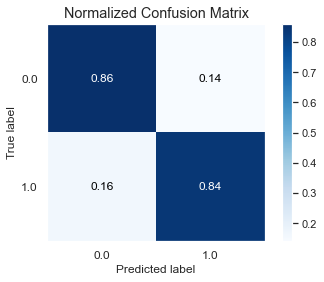

In [85]:
#Plotting Confusion Matrix Adaptive Boost model
skplt.metrics.plot_confusion_matrix(y_test, predrf, normalize=True)

### AdaBoost Classifier

In [86]:
#Instantiating model and fitting model

adaboost = AdaBoostClassifier()
adaboost.fit(X_train,y_train)


AdaBoostClassifier()

In [87]:
# Performing Evaluation metrics for our model
predada=adaboost.predict(X_test)
print('Accuracy Score for AdaBoost is :',round(accuracy_score(y_test,predada),4)*100,'% \n')
print('Confusion Matrix of AdaBoost : \n',confusion_matrix(y_test,predada), '\n')
print('Classification AdaBoost : \n',classification_report(y_test,predada))

Accuracy Score for AdaBoost is : 80.71000000000001 % 

Confusion Matrix of AdaBoost : 
 [[4067  901]
 [1003 3901]] 

Classification AdaBoost : 
               precision    recall  f1-score   support

         0.0       0.80      0.82      0.81      4968
         1.0       0.81      0.80      0.80      4904

    accuracy                           0.81      9872
   macro avg       0.81      0.81      0.81      9872
weighted avg       0.81      0.81      0.81      9872



array([[4067,  901],
       [1003, 3901]], dtype=int64)

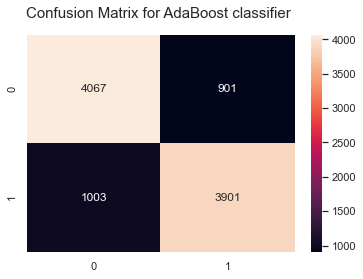

In [97]:
cm = confusion_matrix(y_test,predada)
#visualize confusion matrix 
sns.heatmap(confusion_matrix(y_test,predada),annot=True,fmt='3.0f')
plt.title('Confusion Matrix for AdaBoost classifier ', y=1.05, size=15)
cm

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

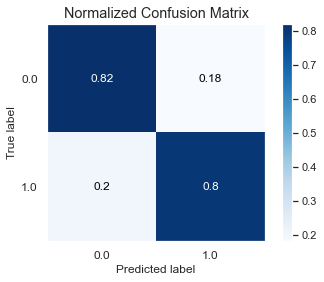

In [89]:
#Plotting Confusion Matrix Adaptive Boost model
skplt.metrics.plot_confusion_matrix(y_test, predada, normalize=True)

### Bagging Classifier

In [90]:
from sklearn.ensemble import BaggingClassifier

In [91]:
#Instantiating model and fitting model

BG = BaggingClassifier()
BG.fit(X_train,y_train)

BaggingClassifier()

In [92]:
# Performing Evaluation metrics for our model
predbg=BG.predict(X_test)
print('Accuracy Score for Bagging Classifier is :',round(accuracy_score(y_test,predbg),4)*100,'% \n')
print('Confusion Matrix of Bagging Classifier is : \n',confusion_matrix(y_test,predbg), '\n')
print('Classification  for Bagging Classifier : \n',classification_report(y_test,predbg))

Accuracy Score for Bagging Classifier is : 83.89999999999999 % 

Confusion Matrix of Bagging Classifier is : 
 [[4234  734]
 [ 855 4049]] 

Classification  for Bagging Classifier : 
               precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      4968
         1.0       0.85      0.83      0.84      4904

    accuracy                           0.84      9872
   macro avg       0.84      0.84      0.84      9872
weighted avg       0.84      0.84      0.84      9872



array([[4234,  734],
       [ 855, 4049]], dtype=int64)

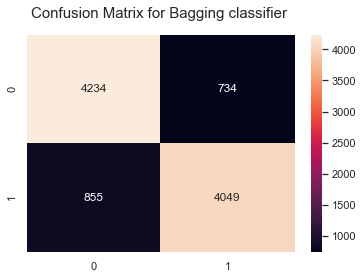

In [98]:
cm = confusion_matrix(y_test,predbg)
#visualize confusion matrix 
sns.heatmap(confusion_matrix(y_test,predbg),annot=True,fmt='3.0f')
plt.title('Confusion Matrix for Bagging classifier ', y=1.05, size=15)
cm

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

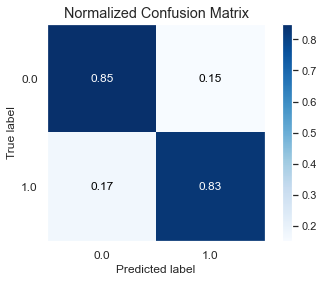

In [94]:
#Plotting Confusion Matrix Adaptive Boost model
skplt.metrics.plot_confusion_matrix(y_test, predbg, normalize=True)

#### Getting Cross - Validation Scores of our Models.

In [95]:
CVscore_LR = cross_val_score(LR,X_smote,y_smote,cv = 10 )
print("Cross validation score of Logistic Regression is :",round(CVscore_LR.mean(),4)*100,'%')

CVscore_DT = cross_val_score(DT,X_smote,y_smote,cv = 10 )
print("Cross validation score of Decision Tree is :", round(CVscore_DT.mean(),4)*100,'%')

CVscore_Knn = cross_val_score(knn,X_smote,y_smote,cv = 10 )
print("Cross validation score of KNeighbors Classifier :", round(CVscore_Knn.mean(),4)*100,'%')

CVscore_RF = cross_val_score(RF,X_smote,y_smote,cv = 10 )
print("Cross validation score of Random Forest Classifier :", round(CVscore_RF.mean(),4)*100,'%')

CVscore_Ada = cross_val_score(adaboost,X_smote,y_smote,cv = 10 )
print("Cross validation score of Adaboost Classifier is :",round(CVscore_Ada.mean(),4)*100,'%')

CVscore_BG = cross_val_score(BG,X_smote,y_smote, cv = 10)
print("Cross validation score of Bagging Classifier:", round(CVscore_BG.mean(),3)*100,'%')

Cross validation score of XGB Classifier is : 66.67 %
Cross validation score of Decision Tree is : 83.06 %
Cross validation score of KNeighbors Classifier : 81.16 %
Cross validation score of Random Forest Classifier : 84.94 %
Cross validation score of Adaboost Classifier is : 80.25999999999999 %
Cross validation score of Bagging Classifier: 84.2 %


### Plotting AUC-ROC Curve

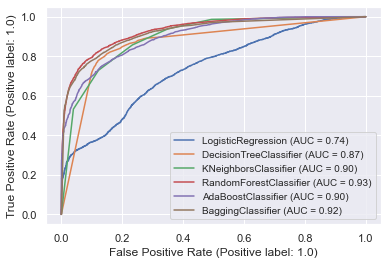

In [99]:
disp = plot_roc_curve(LR,X_test,y_test)

plot_roc_curve(DT ,X_test,y_test,ax=disp.ax_)   #ax_ - axes with confusion matrix

plot_roc_curve(knn,X_test,y_test, ax=disp.ax_)

plot_roc_curve(RF,X_test,y_test, ax=disp.ax_)

plot_roc_curve(adaboost,X_test,y_test, ax=disp.ax_)

plot_roc_curve(BG,X_test,y_test, ax=disp.ax_)

plt.legend(prop={'size':10}, loc = 'best')


plt.show()

### Conclusion :
__Bagging Classifier is giving us the best scores among all other models__
- Cross Validation Score - 0.84
- Accuracy Score - 0.84
- Precision - 0.84
- Recall - 0.84
- F1 score - 0.83
- auc-roc-score - 0.92


## Hyperparameter Tuning of Best Model

In [100]:
param_grid = {
    'base_estimator' :['DecisionTreeClassifier',
                           'KNeighborsClassifier',
                           'SVC(gamma="scale")', None],
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators':[10,15,20,25,30],
    'bootstrap': [True,False],
    'warm_start': [True,False]
}

In [101]:
randomcv = RandomizedSearchCV(estimator = BG, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)

In [102]:
randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END base_estimator=SVC(gamma="scale"), bootstrap=True, max_samples=0.05, n_estimators=25, warm_start=False; total time=   0.0s
[CV] END base_estimator=SVC(gamma="scale"), bootstrap=True, max_samples=0.05, n_estimators=25, warm_start=False; total time=   0.0s
[CV] END base_estimator=SVC(gamma="scale"), bootstrap=True, max_samples=0.05, n_estimators=25, warm_start=False; total time=   0.0s
[CV] END base_estimator=SVC(gamma="scale"), bootstrap=False, max_samples=0.5, n_estimators=10, warm_start=True; total time=   0.0s
[CV] END base_estimator=SVC(gamma="scale"), bootstrap=False, max_samples=0.5, n_estimators=10, warm_start=True; total time=   0.0s
[CV] END base_estimator=SVC(gamma="scale"), bootstrap=False, max_samples=0.5, n_estimators=10, warm_start=True; total time=   0.0s
[CV] END base_estimator=DecisionTreeClassifier, bootstrap=True, max_samples=0.2, n_estimators=20, warm_start=False; total time=   0.0s
[CV] END base

RandomizedSearchCV(cv=3, estimator=BaggingClassifier(), n_iter=100,
                   param_distributions={'base_estimator': ['DecisionTreeClassifier',
                                                           'KNeighborsClassifier',
                                                           'SVC(gamma="scale")',
                                                           None],
                                        'bootstrap': [True, False],
                                        'max_samples': [0.05, 0.1, 0.2, 0.5],
                                        'n_estimators': [10, 15, 20, 25, 30],
                                        'warm_start': [True, False]},
                   random_state=42, verbose=2)

In [103]:
#To check the best parameters to increase model Accuracy
randomcv.best_params_

{'warm_start': False,
 'n_estimators': 25,
 'max_samples': 0.5,
 'bootstrap': False,
 'base_estimator': None}

In [104]:
Model = BaggingClassifier(base_estimator = None, warm_start = False, n_estimators = 25, max_samples = 0.5, bootstrap = False)

In [105]:
Model.fit(X_train,y_train)

BaggingClassifier(bootstrap=False, max_samples=0.5, n_estimators=25)

In [106]:
# Performing Evaluation metrics for our model
y_pred = Model.predict(X_test)
print('Accuracy Score for Random Forest Classifier is :',round(accuracy_score(y_test,y_pred),4)*100,'% \n')
print('Confusion Matrix of Random Forest Classifier : \n',confusion_matrix(y_test,y_pred), '\n')
print('Classification Random Forest Classifier : \n',classification_report(y_test,y_pred))

Accuracy Score for Random Forest Classifier is : 84.09 % 

Confusion Matrix of Random Forest Classifier : 
 [[4231  737]
 [ 834 4070]] 

Classification Random Forest Classifier : 
               precision    recall  f1-score   support

         0.0       0.84      0.85      0.84      4968
         1.0       0.85      0.83      0.84      4904

    accuracy                           0.84      9872
   macro avg       0.84      0.84      0.84      9872
weighted avg       0.84      0.84      0.84      9872



array([[4231,  737],
       [ 834, 4070]], dtype=int64)

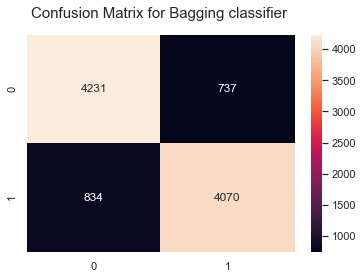

In [107]:
cm = confusion_matrix(y_test,y_pred)

#visualize confusion matrix 

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f')
plt.title('Confusion Matrix for Bagging classifier ', y=1.05, size=15)
cm

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

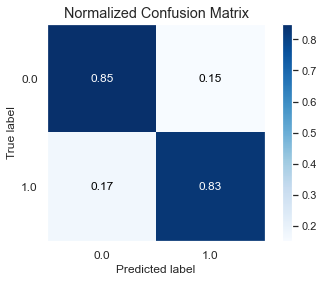

In [108]:
#Plotting Confusion Matrix Bagging Classifier model
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

## Saving Final Model

In [109]:
joblib.dump(Model,"CensusIncomeAnalysis.pkl")

['CensusIncomeAnalysis.pkl']

## Loading Our Model for Final Predictions

In [110]:
model = joblib.load("CensusIncomeAnalysis.pkl")

In [111]:
#predicting test data using loaded model
prediction = model.predict(X_test)
prediction

array([0., 1., 1., ..., 1., 1., 0.])

In [112]:
#Analysing Predicted vs Actual
results = pd.DataFrame()
results['Predicted'] = prediction
results['Actual'] = y
results

,Predicted,Actual
0,0.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
9867,1.0,1.0
9868,0.0,0.0
9869,1.0,0.0
9870,1.0,1.0


In [113]:
#Converting the saved file into .csv format
results.to_csv('Results.csv',index = True)